# Music Collaboration Network: An Analysis Based on MusicBrainz  
**Author:** Albert Matarin Luque  

**Date:** 2025-05-10  

---

## 1. Introduction

In this notebook we explore the collaboration networks of a selected set of artists  
(using data from MusicBrainz) to visualize two types of relationships:

- **Internal collaborations**: members within Linkin Park and their internal interactions.  
- **External collaborations**: shared recording credits with other artists.  

The main goals are to demonstrate:  

1. How to use the MusicBrainz REST API with Python.  
2. Data modeling for networks (nodes and edges).  
3. Advanced visualization with NetworkX and PyVis/Plotly.  

---

## 2. Objectives

- Retrieve the MBIDs of the 6 selected artists.  
- Download, for each artist, all recordings with `inc=artist-credits`.  
- Build an undirected graph where the edge weight represents the number of tracks shared.  
- Enrich nodes with metadata (type, country, debut year, note, degree).  
- Generate:  
  - Static graphs with Matplotlib.  
  - Interactive visualization exported to HTML.  

---

## 3. Data sources

- **MusicBrainz API**  
  - General documentation: <https://musicbrainz.org/doc/MusicBrainz_API>  
  - Key endpoints:  
    - `/ws/2/artist?query={name}&fmt=json`  
    - `/ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json`  

---

## 4. Project structure

```text
/project-root
├─ data/                  
│  ├─ recordings.json        # Raw recording data  
│  ├─ artist_metadata.json   # Enriched artist metadata  
│  └─ artist_mbids.json      # Mapping of artist names to MBIDs  
├─ results/                 
│  ├─ network.html           # Interactive graph  
│  └─ static_network.png     # Static visualization  
├─ MusicBrainz-Collab-Network.ipynb  # Main Jupyter notebook  
├─ README.md                 # Project description  
└─ requirements.txt          # Environment dependencies  


## Step 1: Fetch MBIDs

In this first step, we obtain the unique identifier (MBID) for each of the six selected artists.  
This identifier will later allow us to retrieve their recordings and credits.

The process is as follows:

1. Define the list of seed artists.  
2. Query the MusicBrainz endpoint `/ws/2/artist` in JSON format.  
3. Extract the MBID from the first search result for each name.  
4. Store the dictionary `{artist: MBID}` and export it for reuse.  

This step also sets up project-wide constants such as the data directory, API configuration,  
and polite rate limiting in accordance with the MusicBrainz guidelines.


In [1]:
# === STEP 1 · Fetch MBIDs for seed artists ==================================
# This cell defines project-wide constants and helpers reused in later steps.

from __future__ import annotations
import time
from pathlib import Path
from typing import Dict, Optional, List
import json
import requests

# ----------------------------
# Project-wide configuration
# ----------------------------
PROJECT_NAME: str = "CollabNetwork"
CONTACT_EMAIL: str = "your_email@example.com"  # <-- update before publishing
BASE_API_URL: str = "https://musicbrainz.org/ws/2"
DATA_DIR: Path = Path("data")
DATA_DIR.mkdir(exist_ok=True)

RATE_LIMIT_SECONDS: float = 1.1     # MusicBrainz polite rate-limit
REQUEST_TIMEOUT: int = 30           # seconds for HTTP requests

# Seed artists (used throughout the project)
ARTISTS: List[str] = [
    "Linkin Park",
    "Evanescence",
    "Metallica",
    "Deftones",
    "System of a Down",
    "Avenged Sevenfold",
]

# MusicBrainz requires a descriptive User-Agent
HEADERS = {
    "User-Agent": f"{PROJECT_NAME}/1.0 ({CONTACT_EMAIL})"
}

# ----------------------------
# Helper: fetch one MBID
# ----------------------------
def fetch_mbid(artist_name: str) -> Optional[str]:
    """
    Return the MBID for the given artist name using MusicBrainz search.
    If no match is found or an HTTP error occurs, return None.
    """
    url = f"{BASE_API_URL}/artist"
    params = {"query": artist_name, "fmt": "json", "limit": 1}

    try:
        resp = requests.get(url, params=params, headers=HEADERS, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        artists = resp.json().get("artists", [])
        return artists[0]["id"] if artists else None
    except requests.RequestException as exc:
        print(f"[WARN] Failed to fetch MBID for '{artist_name}': {exc}")
        return None

# ----------------------------
# Fetch MBIDs for all seeds
# ----------------------------
artist_mbids: Dict[str, Optional[str]] = {}
for artist_name in ARTISTS:
    mbid = fetch_mbid(artist_name)
    artist_mbids[artist_name] = mbid
    print(f"{artist_name}: {mbid}")
    time.sleep(RATE_LIMIT_SECONDS)  # be polite with the API

# Derived mapping used by later steps (Step 3 expects MBID->Name for 'principales')
principales: Dict[str, str] = {mbid: name for name, mbid in artist_mbids.items() if mbid}

# Persist results for reuse (Steps 2–5 load from here if needed)
with open(DATA_DIR / "artist_mbids.json", "w", encoding="utf-8") as f:
    json.dump(artist_mbids, f, ensure_ascii=False, indent=2)

print("\nSaved MBIDs to", DATA_DIR / "artist_mbids.json")
print("principales (MBID -> Name):", len(principales))


Linkin Park: f59c5520-5f46-4d2c-b2c4-822eabf53419
Evanescence: f4a31f0a-51dd-4fa7-986d-3095c40c5ed9
Metallica: 65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab
Deftones: 7527f6c2-d762-4b88-b5e2-9244f1e34c46
System of a Down: cc0b7089-c08d-4c10-b6b0-873582c17fd6
Avenged Sevenfold: 24e1b53c-3085-4581-8472-0b0088d2508c

Saved MBIDs to data\artist_mbids.json
principales (MBID -> Name): 6


## Step 2: Download Recordings and Artist Credits

In this step we retrieve **all recordings** of each artist together with their artist credits.  
These credits indicate with which other artists each one has collaborated.  

**Specific objectives**:

1. Define the function `fetch_recordings_for_artist(mbid)` that:  
   - Iteratively calls the endpoint:  
     ```
     /ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json&limit=100&offset={offset}
     ```
   - Automatically paginates until all recordings (`recording-count`) are downloaded.  
   - Returns a list of `recording` objects, each including the corresponding `artist-credit`.  

2. Call this function for each artist in `artist_mbids` and:  
   - Store the results in a dictionary of the form:  
     ```python
     {
       "Linkin Park": [ {recording1}, {recording2}, … ],
       "Evanescence": [ … ],
       …
     }
     ```
   - Serialize this dictionary into `/data/recordings.json` as a backup for later steps.  

3. Print a quick summary of the number of recordings per artist and show a couple of sample entries.  


In [2]:
# === STEP 2 · Fetch artist recordings with paging and caching ================

from __future__ import annotations
import json
import time
from pathlib import Path
from typing import Dict, List, Any, Optional

import requests

# Reused from Step 1 (make sure Step 1 ran):
# BASE_API_URL, HEADERS, DATA_DIR, RATE_LIMIT_SECONDS, REQUEST_TIMEOUT
# ARTISTS, artist_mbids

# ---------------------------------------------------------------------
# Configuration for Step 2
# ---------------------------------------------------------------------
PAGE_LIMIT: int = 100
FORCE_REFRESH: bool = False  # set True to ignore cache and re-download
RECORDINGS_PATH: Path = DATA_DIR / "recordings.json"

# Optional: single shared HTTP session for better performance
HTTP = requests.Session()
HTTP.headers.update(HEADERS)

def get_json(endpoint: str, params: Dict[str, Any]) -> Dict[str, Any]:
    """Small helper to GET JSON with retries and polite throttling."""
    url = f"{BASE_API_URL}{endpoint}"
    attempts = 3
    backoff = 1.5
    for attempt in range(1, attempts + 1):
        try:
            resp = HTTP.get(url, params=params, timeout=REQUEST_TIMEOUT)
            resp.raise_for_status()
            data = resp.json()
            # Polite rate limit after a successful request
            time.sleep(RATE_LIMIT_SECONDS)
            return data
        except requests.RequestException as exc:
            if attempt == attempts:
                raise
            wait = backoff ** attempt
            print(f"[WARN] {exc}. Retrying in {wait:.1f}s ({attempt}/{attempts})…")
            time.sleep(wait)
    return {}

def fetch_recordings_for_artist(artist_mbid: str, page_limit: int = PAGE_LIMIT) -> List[Dict[str, Any]]:
    """
    Download ALL recordings for a given artist MBID, including artist credits.
    Uses bounded paging (no while-True) based on 'recording-count'.
    """
    # 1) First page to learn total count
    first_params = {
        "artist": artist_mbid,
        "inc": "artist-credits",
        "fmt": "json",
        "limit": page_limit,
        "offset": 0,
    }
    first_page = get_json("/recording", first_params)
    total_count: int = int(first_page.get("recording-count", 0))
    recording_list: List[Dict[str, Any]] = list(first_page.get("recordings", []))

    if total_count <= len(recording_list):
        return recording_list

    # 2) Remaining pages (bounded for-loop)
    for current_offset in range(page_limit, total_count, page_limit):
        params = {
            "artist": artist_mbid,
            "inc": "artist-credits",
            "fmt": "json",
            "limit": page_limit,
            "offset": current_offset,
        }
        page = get_json("/recording", params)
        recording_list.extend(page.get("recordings", []))

    return recording_list

def load_recordings_from_cache(path: Path = RECORDINGS_PATH) -> Optional[Dict[str, List[Dict[str, Any]]]]:
    if path.exists() and not FORCE_REFRESH:
        print(f"[CACHE] Using cached recordings from {path}")
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    return None

def save_recordings_to_cache(data: Dict[str, List[Dict[str, Any]]], path: Path = RECORDINGS_PATH) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"[CACHE] Saved recordings to {path}")

# ---------------------------------------------------------------------
# Main: build or load `all_recordings`
# ---------------------------------------------------------------------
all_recordings: Dict[str, List[Dict[str, Any]]] = load_recordings_from_cache() or {}

if not all_recordings:
    print("[INFO] Cache not found or FORCE_REFRESH=True → downloading from API…")
    for artist_name, artist_mbid in artist_mbids.items():
        if not artist_mbid:
            print(f"[WARN] Skipping '{artist_name}' (no MBID).")
            continue
        print(f"Downloading recordings for {artist_name}…")
        try:
            recordings = fetch_recordings_for_artist(artist_mbid, page_limit=PAGE_LIMIT)
            all_recordings[artist_name] = recordings
            print(f"→ {artist_name}: {len(recordings)} recordings")
        except Exception as exc:
            print(f"[ERROR] Failed '{artist_name}': {exc}")
    save_recordings_to_cache(all_recordings)

# ---------------------------------------------------------------------
# Quick summary for the notebook
# ---------------------------------------------------------------------
print("\nSummary — recordings per artist:")
for artist_name in ARTISTS:
    count = len(all_recordings.get(artist_name, []))
    print(f"- {artist_name}: {count}")

example_artist = ARTISTS[0]
print(f"\nExamples from {example_artist}:")
for recording in all_recordings.get(example_artist, [])[:2]:
    title = recording.get("title", "—")
    rec_id = recording.get("id", "—")
    credits = [ac["artist"]["name"] for ac in recording.get("artist-credit", [])]
    print(f"  • {title} ({rec_id}), credits: {credits}")


[CACHE] Using cached recordings from data\recordings.json

Summary — recordings per artist:
- Linkin Park: 2023
- Evanescence: 873
- Metallica: 18610
- Deftones: 898
- System of a Down: 1044
- Avenged Sevenfold: 402

Examples from Linkin Park:
  • A Place for My Head (Long Down Vocal Instrumental Mix Project) (00f862cf-0386-43e8-93b3-e5ef3875358f), credits: ['Linkin Park']
  • A Place for My Head (02995581-eaa6-4c28-a683-ef2e6af17c31), credits: ['Linkin Park']


## Step 3: Build the Collaboration Graph

In this step we construct an **undirected, weighted graph** of collaborations.

### What we build

- **Nodes**
  - The 6 **principal bands**: Linkin Park, Evanescence, Metallica, Deftones, System of a Down, Avenged Sevenfold.
  - **Internal members** of each principal band.
  - **External collaborators** appearing in recording credits.

- **Edges**
  - **Internal edges**: band ↔ member (weight = 1; no duplicates).
  - **External edges**: for every recording, if two artists A and B co-appear in `artist-credit`, we increment the edge weight **w(A,B)** by 1.

- **Node attributes**
  - `type`: `"grupo"` for bands, `"solista"` for people (as provided by MusicBrainz).
  - `zone`: `"internal"` for band members; `"external"` for principal bands and external collaborators.
  - `degree`: weighted degree (sum of incident edge weights).

### Pipeline (high level)

1. **Collect MBIDs** to cover principals, their members, and all collaborators found in recordings.
2. **Fetch & normalize artist metadata** (`type`, `country`, `debut`, `note`) with retry + polite pacing.  
   Cache it in `data/artist_metadata.json`.
3. **Add nodes** for principals (zone=`external`) and **attach internal members** (zone=`internal`) via edges (weight=1).
4. **Scan recordings** and **add weighted co-credit edges** between all pairs of credited artists.
5. **Compute weighted degree** for every node and store it as `degree`.

> **Caching note:** the step will reuse `data/artist_metadata.json` if present.  
> Set `FORCE_FULL_REFRESH = True` to rebuild it from the API.

In [3]:
# === STEP 3 · Build collaboration graph (robust cache + clean graph build) ===
from __future__ import annotations

import json
import math
import random
import time
from pathlib import Path
from typing import Any, Dict, List, Tuple

import networkx as nx
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from itertools import combinations

# ---------------------------------------------------------------------------
# Globals reused from previous steps (already defined):
#   BASE_API_URL, HEADERS, DATA_DIR
#   artist_mbids  (Dict[str, str])   # name -> MBID
#   principales   (Dict[str, str])   # MBID -> name
#   all_recordings: Dict[str, List[dict]]
# ---------------------------------------------------------------------------

# Output/cache paths
METADATA_PATH: Path = DATA_DIR / "artist_metadata.json"

# Refresh and politeness config
FORCE_FULL_REFRESH: bool = False      # Full rebuild of artist_metadata.json
REQUEST_DELAY_SEC: float = 1.3       # ≈1 req/s + margin
MAX_ATTEMPTS: int = 5                # app-level retries per artist
HTTP_RETRIES: int = 3                # transport retries inside requests
BACKOFF_BASE: float = 1.0            # backoff base (1s, 2s, 4s, ...)
JITTER_SEC: float = 0.25             # small jitter to desync bursts

# ----------------------------- HTTP session ---------------------------------
def make_session() -> requests.Session:
    session = requests.Session()
    retry = Retry(
        total=HTTP_RETRIES,
        backoff_factor=0.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET"]),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    session.headers.update(HEADERS)
    return session

HTTP = make_session()

def polite_sleep(multiplier: float = 1.0) -> None:
    """Sleep to respect API politeness (base delay + jitter)."""
    wait = max(0.0, REQUEST_DELAY_SEC * multiplier) + random.uniform(0.0, JITTER_SEC)
    time.sleep(wait)

# --------------------------- MusicBrainz fetchers ----------------------------
def get_artist_json(mbid: str, inc: str = "") -> Dict[str, Any]:
    """Fetch artist JSON with app-level retries + polite pacing."""
    url = f"{BASE_API_URL}/artist/{mbid}"
    params = {"fmt": "json"}
    if inc:
        params["inc"] = inc

    for attempt in range(MAX_ATTEMPTS):
        # exponential backoff: 1x, 2x, 4x, 8x...
        polite_sleep(1.0 if attempt == 0 else (2 ** attempt) * BACKOFF_BASE)
        try:
            resp = HTTP.get(url, params=params, timeout=30)
            resp.raise_for_status()
            return resp.json()
        except requests.RequestException as exc:
            if attempt == MAX_ATTEMPTS - 1:
                # Let caller decide fallback/merge
                raise
            # try again
    # Should not reach here
    raise RuntimeError(f"Exhausted attempts for MBID {mbid}")

def normalize_metadata(raw: Dict[str, Any]) -> Dict[str, Any]:
    """Map MusicBrainz fields to the normalized structure used by steps 4–5."""
    return {
        "type":    "solista" if raw.get("type") == "Person" else "grupo",
        "country": raw.get("country", "–"),
        "debut":   raw.get("life-span", {}).get("begin", "–"),
        "note":    raw.get("disambiguation", ""),
    }

def fetch_artist_metadata(mbid: str) -> Dict[str, Any]:
    raw = get_artist_json(mbid, inc="aliases+tags")
    return normalize_metadata(raw)

def fetch_band_members(band_mbid: str) -> List[Tuple[str, str]]:
    """Return list of (member_name, member_mbid) for a band MBID."""
    try:
        raw = get_artist_json(band_mbid, inc="artist-rels")
    except requests.RequestException:
        return []
    members: List[Tuple[str, str]] = []
    for rel in raw.get("relations", []):
        if rel.get("type") == "member of band":
            artist = rel.get("artist")
            if artist and artist.get("id"):
                members.append((artist["name"], artist["id"]))
    return members

# -------------------------- Cache merge policy -------------------------------
def is_fallback(meta: Dict[str, Any] | None) -> bool:
    """Detect very weak entries (both country and debut are '–')."""
    if not meta:
        return True
    return (meta.get("country") == "–") and (meta.get("debut") == "–")

def merge_preserving_good(old: Dict[str, Any] | None, new: Dict[str, Any]) -> Dict[str, Any]:
    """
    Never overwrite good cache with weak 'fallback' data.
    Also backfill missing fields from old (type/country/debut/note).
    """
    if old and is_fallback(new) and not is_fallback(old):
        return old
    if old:
        for key in ("type", "country", "debut", "note"):
            if (new.get(key) in (None, "", "–")) and (old.get(key) not in (None, "")):
                new[key] = old[key]
    return new

# ------------------------ Collect universe of MBIDs --------------------------
def collect_all_mbids() -> List[str]:
    mbids: set[str] = set(principales.keys())  # principals (MBID -> name) keys
    # from recordings: all collaborators found in artist-credit
    for recordings in all_recordings.values():
        for recording in recordings:
            for credit in recording.get("artist-credit", []):
                mbids.add(credit["artist"]["id"])
    # from band members of each principal band
    for band_mbid in principales.keys():
        for _, member_mbid in fetch_band_members(band_mbid):
            mbids.add(member_mbid)
    return sorted(mbids)

# ------------------------ Build or refresh artist metadata -------------------
previous_cache: Dict[str, Dict[str, Any]] = {}
if METADATA_PATH.exists():
    try:
        previous_cache = json.loads(METADATA_PATH.read_text(encoding="utf-8"))
    except Exception:
        previous_cache = {}

if FORCE_FULL_REFRESH or not previous_cache:
    all_mbids_list = collect_all_mbids()
    print(f"[INFO] Fetching metadata for {len(all_mbids_list)} artists (full refresh)…")

    artist_metadata: Dict[str, Dict[str, Any]] = {}
    count_fresh = 0
    count_merged_from_cache = 0
    count_pure_fallback = 0

    for index, mbid in enumerate(all_mbids_list, 1):
        try:
            fresh = fetch_artist_metadata(mbid)
            merged = merge_preserving_good(previous_cache.get(mbid), fresh)
            artist_metadata[mbid] = merged
            if merged is fresh:
                count_fresh += 1
            else:
                count_merged_from_cache += 1
        except requests.RequestException:
            # if fetch fails after retries, keep old (if any) or store minimal fallback
            old = previous_cache.get(mbid)
            if old:
                artist_metadata[mbid] = old
                count_merged_from_cache += 1
            else:
                artist_metadata[mbid] = {"type": "grupo", "country": "–", "debut": "–", "note": ""}
                count_pure_fallback += 1

        if index % 25 == 0 or index == len(all_mbids_list):
            print(f"  … {index}/{len(all_mbids_list)}")

    METADATA_PATH.write_text(json.dumps(artist_metadata, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"[CACHE] Saved metadata to {METADATA_PATH}")
    print(f"[SUMMARY] fresh={count_fresh}, merged_from_cache={count_merged_from_cache}, pure_fallback={count_pure_fallback}")
else:
    artist_metadata = previous_cache
    print(f"[CACHE] Loaded metadata from {METADATA_PATH}")

# ------------------------------ Build the graph ------------------------------
collab_graph = nx.Graph()

# 1) Add principal bands as nodes (zone='external')
for band_mbid, band_name in principales.items():
    meta = artist_metadata.get(band_mbid, {})
    collab_graph.add_node(
        band_name,
        mbid=band_mbid,
        type=meta.get("type", "grupo"),
        country=meta.get("country", "–"),
        debut=meta.get("debut", "–"),
        note=meta.get("note", ""),
        zone="external",
    )

# 2) Add internal band members and link them to their band (weight=1)
band_members: Dict[str, List[Dict[str, Any]]] = {band_name: [] for band_name in principales.values()}

for band_mbid, band_name in principales.items():
    members_set = set(fetch_band_members(band_mbid))
    print(f"Members of {band_name}: {[member for member, _ in members_set]}")
    for member_name, member_mbid in members_set:
        meta = artist_metadata.get(member_mbid, {})
        node_attrs = {
            "mbid":    member_mbid,
            "type":    meta.get("type", "solista"),
            "country": meta.get("country", "–"),
            "debut":   meta.get("debut", "–"),
            "note":    meta.get("note", ""),
            "zone":    "internal",
        }
        band_members[band_name].append({"name": member_name, **node_attrs})
        collab_graph.add_node(member_name, **node_attrs)
        if not collab_graph.has_edge(band_name, member_name):
            collab_graph.add_edge(band_name, member_name, weight=1)

# 3) Add external collaboration edges from recordings (undirected, weighted)
for artist_name, recordings in all_recordings.items():
    for recording in recordings:
        credits = recording.get("artist-credit", [])
        credit_names: List[str] = []

        # ensure nodes exist with metadata (zone='external' for non-internal)
        for credit in credits:
            collaborator_name = credit["artist"]["name"]
            collaborator_mbid = credit["artist"]["id"]
            if not collab_graph.has_node(collaborator_name):
                meta = artist_metadata.get(collaborator_mbid, {})
                collab_graph.add_node(
                    collaborator_name,
                    mbid=collaborator_mbid,
                    type=meta.get("type", "solista"),
                    country=meta.get("country", "–"),
                    debut=meta.get("debut", "–"),
                    note=meta.get("note", ""),
                    zone="external",
                )
            credit_names.append(collaborator_name)

        # add/accumulate weights for all unordered pairs in this recording
        for name_a, name_b in combinations(credit_names, 2):
            current_weight = collab_graph[name_a][name_b]["weight"] + 1 if collab_graph.has_edge(name_a, name_b) else 1
            collab_graph.add_edge(name_a, name_b, weight=current_weight)

# 4) Compute weighted degree for all nodes
weighted_degree: Dict[str, float] = dict(collab_graph.degree(weight="weight"))
nx.set_node_attributes(collab_graph, weighted_degree, "degree")

# Retro-compatible alias for later steps (your Step 5.1/5.2 expect 'G')
G = collab_graph

# ------------------------------ Quick summary --------------------------------
print(f"Total nodes: {collab_graph.number_of_nodes()}")
print(f"Total edges: {collab_graph.number_of_edges()}")
for node_name in list(collab_graph.nodes)[:5]:
    print(node_name, collab_graph.nodes[node_name])


[CACHE] Loaded metadata from data\artist_metadata.json
Members of Linkin Park: ['Joseph “Joe” Hahn', 'David Michael Farrell', 'Emily Armstrong', 'Colin Brittain', 'Chester Bennington', 'Mark Wakefield', 'Brad Delson', 'Mike Shinoda', 'Rob Bourdon']
Members of Evanescence: ['William Boyd', 'Troy McLawhorn', 'John LeCompt', 'Will Hunt', 'Rocky Gray', 'Jen Majura', 'Amy Lee', 'Tim McCord', 'Emma Anzai', 'Ben Moody', 'David Hodges', 'Terry Balsamo']
Members of Metallica: ['Kirk Hammett', 'James Hetfield', 'Jason Newsted', 'Dave Mustaine', 'Ron McGovney', 'Robert Trujillo', 'Lars Ulrich', 'Cliff Burton']
Members of Deftones: ['Abe Cunningham', 'Stephen Carpenter', 'Chi Cheng', 'Frank Delgado', 'Chino Moreno', 'Sergio Vega']
Members of System of a Down: ['Shavo Odadjian', 'Daron Malakian', 'Serj Tankian', 'Ontronik Khachaturian', 'John Dolmayan', 'Andy Khatchaturian']
Members of Avenged Sevenfold: ['Arin Ilejay', 'The Rev', 'Johnny Christ', 'Brooks Wackerman', 'Justin Sane', 'Zacky Vengeance

## Step 4 — Filtering & Preliminary Analysis

In this step we refine the collaboration graph to keep **relevant external ties** while **always preserving the internal structure** of each principal band.

1. **Weak-edge filtering**  
   - Define a weight threshold `threshold` (e.g., `2`).  
   - **Remove** external edges with `weight < threshold`.  
   - **Keep** all **internal** edges (principal band ↔ band member) regardless of weight.

2. **Filtered graph summary**  
   - Report the total **nodes** and **edges** after filtering.  
   - Provide counts by **type** (`group` / `solo`) and by **zone** (`external` / `internal`).

3. **Degree analysis (weighted)**  
   - Compute weighted degree:  
     ```python
     degree_filtered = dict(Gf.degree(weight="weight"))
     ```  
   - List the **Top-5 nodes by weighted degree**.  
   - Show basic statistics of the distribution (**min**, **median**, **max**).  
   - Optionally split the Top-5 by **zone** (external vs internal).

4. **Connectivity**  
   - Report the number of **connected components**.  
   - Identify **isolated nodes** (degree = 0).  
   - Report the size of the **giant component**.

5. **Distribution plot**  
   - Display a histogram of weighted degrees for the filtered graph to visualize skew / hubs.


[INFO] Using weight threshold = 2
[SUMMARY] Filtered graph: 281 nodes, 191 edges
[SUMMARY] Nodes by type: {'grupo': 58, 'solista': 223}
[SUMMARY] Nodes by zone: {'external': 232, 'internal': 49}

[DEGREE] Top 5 nodes by weighted degree:
  • Linkin Park: 277
  • Metallica: 247
  • San Francisco Symphony: 70
  • JAY‐Z: 65
  • Eminem: 46

[DEGREE] Stats:
  - Min   : 0
  - Median: 1
  - Max   : 277

[DEGREE] Top 5 external nodes: [('Linkin Park', 277, 'external'), ('Metallica', 247, 'external'), ('San Francisco Symphony', 70, 'external'), ('JAY‐Z', 65, 'external'), ('Eminem', 46, 'external')]
[DEGREE] Top 5 internal nodes: [('Jason Newsted', 17, 'internal'), ('Mike Shinoda', 14, 'internal'), ('Dave Mustaine', 10, 'internal'), ('Joseph “Joe” Hahn', 9, 'internal'), ('Ron McGovney', 8, 'internal')]

[CONNECTIVITY] Connected components: 137
[CONNECTIVITY] Isolated nodes     : 135
[CONNECTIVITY] Giant component size: 131


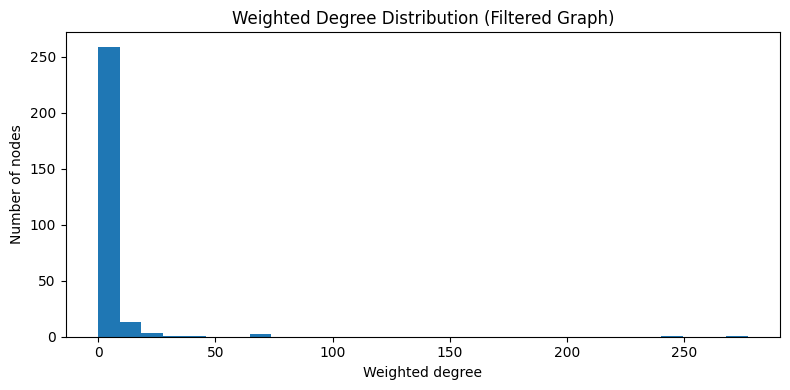

In [4]:
# === STEP 4 · Filter graph and run preliminary analysis ======================

from __future__ import annotations
from typing import Dict, List, Tuple
from collections import Counter
from statistics import median
import networkx as nx
import matplotlib.pyplot as plt

# Reused globals from previous steps:
# - collab_graph: nx.Graph                   (full graph)
# - band_members: Dict[str, List[dict]]      (per-band member metadata)
# - principales: Dict[str, str]              (MBID -> Band Name)

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
DEFAULT_THRESHOLD: int = 2  # keep external edges with weight >= threshold

# ---------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------
def is_internal_member(node_name: str) -> bool:
    """Return True if node_name is a listed member of any principal band."""
    for members in band_members.values():
        if any(m.get("name") == node_name for m in members):
            return True
    return False

def is_principal_band(node_name: str) -> bool:
    """Return True if node_name is one of the 6 principal bands."""
    return node_name in principales.values()

def edge_is_internal(node_a: str, node_b: str) -> bool:
    """
    Internal edges are the band <-> member links of principal bands.
    We keep these regardless of weight.
    """
    return (
        (is_principal_band(node_a) and is_internal_member(node_b)) or
        (is_principal_band(node_b) and is_internal_member(node_a))
    )

# ---------------------------------------------------------------------
# Build filtered graph
# ---------------------------------------------------------------------
def build_filtered_graph(
    source_graph: nx.Graph,
    threshold: int = DEFAULT_THRESHOLD
) -> nx.Graph:
    """
    Copy all nodes and attributes. Keep:
      - All internal edges (band <-> member of a principal band), any weight
      - External edges with weight >= threshold
    """
    filtered = nx.Graph()
    # copy nodes with attributes
    for node_name, attrs in source_graph.nodes(data=True):
        filtered.add_node(node_name, **attrs)

    # selective edges
    for node_a, node_b, attrs in source_graph.edges(data=True):
        weight = attrs.get("weight", 0)
        if edge_is_internal(node_a, node_b) or weight >= threshold:
            filtered.add_edge(node_a, node_b, weight=weight)

    # recompute weighted degree in filtered graph
    weighted_degree = dict(filtered.degree(weight="weight"))
    nx.set_node_attributes(filtered, weighted_degree, "degree")

    return filtered

# ---------------------------------------------------------------------
# Execute filtering
# ---------------------------------------------------------------------
threshold: int = DEFAULT_THRESHOLD
print(f"[INFO] Using weight threshold = {threshold}")
filtered_graph: nx.Graph = build_filtered_graph(collab_graph, threshold=threshold)

# ---------------------------------------------------------------------
# Summary counts
# ---------------------------------------------------------------------
num_nodes = filtered_graph.number_of_nodes()
num_edges = filtered_graph.number_of_edges()
print(f"[SUMMARY] Filtered graph: {num_nodes} nodes, {num_edges} edges")

node_types = Counter(nx.get_node_attributes(filtered_graph, "type").values())
node_zones = Counter(nx.get_node_attributes(filtered_graph, "zone").values())
print("[SUMMARY] Nodes by type:", dict(node_types))
print("[SUMMARY] Nodes by zone:", dict(node_zones))

# ---------------------------------------------------------------------
# Degree analysis
# ---------------------------------------------------------------------
weighted_degree = dict(filtered_graph.degree(weight="weight"))
degree_values = list(weighted_degree.values()) if weighted_degree else [0]

top5_overall = sorted(weighted_degree.items(), key=lambda kv: kv[1], reverse=True)[:5]
print("\n[DEGREE] Top 5 nodes by weighted degree:")
for node_name, deg in top5_overall:
    print(f"  • {node_name}: {deg}")

deg_min = min(degree_values)
deg_med = median(degree_values)
deg_max = max(degree_values)
print("\n[DEGREE] Stats:")
print(f"  - Min   : {deg_min}")
print(f"  - Median: {deg_med}")
print(f"  - Max   : {deg_max}")

# Top-5 by zone (external vs internal)
annotated_degrees = [(n, d, filtered_graph.nodes[n].get("zone", "—")) for n, d in weighted_degree.items()]
top_external = sorted((row for row in annotated_degrees if row[2] == "external"), key=lambda x: x[1], reverse=True)[:5]
top_internal = sorted((row for row in annotated_degrees if row[2] == "internal"), key=lambda x: x[1], reverse=True)[:5]
print("\n[DEGREE] Top 5 external nodes:", top_external)
print("[DEGREE] Top 5 internal nodes:", top_internal)

# ---------------------------------------------------------------------
# Connectivity
# ---------------------------------------------------------------------
num_components = nx.number_connected_components(filtered_graph)
isolated_nodes = list(nx.isolates(filtered_graph))
largest_component_nodes = max(nx.connected_components(filtered_graph), key=len) if num_nodes else set()
print(f"\n[CONNECTIVITY] Connected components: {num_components}")
print(f"[CONNECTIVITY] Isolated nodes     : {len(isolated_nodes)}")
print(f"[CONNECTIVITY] Giant component size: {len(largest_component_nodes)}")

# ---------------------------------------------------------------------
# Histogram (degree distribution)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(degree_values, bins=30)  # no explicit colors/styles per your guidelines
plt.title("Weighted Degree Distribution (Filtered Graph)")
plt.xlabel("Weighted degree")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.show()


### Step-4 Takeaway

- The filtered graph (threshold ≥ 2) contains **281 nodes** and **191 edges**, showing a much sparser structure compared to the unfiltered version.  
- **Linkin Park** and **Metallica** clearly dominate the network with the highest weighted degrees, while other hubs such as **San Francisco Symphony**, **JAY-Z**, and **Eminem** emerge as key external collaborators.  
- The weighted degree distribution is highly skewed: many nodes have very few or no connections (median = 1), while a few hubs concentrate the majority of collaborations (max = 277).  
- The graph splits into **137 connected components**, with **135 isolated nodes**, but still contains a **giant component of 131 nodes**, which concentrates the most relevant collaborations.  
- This confirms that applying the threshold highlights the strongest and most meaningful ties, at the cost of leaving a large fraction of peripheral artists disconnected.


## Step 5: Static and Interactive Visualization

In this step, we will generate two complementary outputs:

## Step 5.1 — Static Visualization (Matplotlib)

This step renders a **static network plot** that highlights the six principal bands and their neighborhoods.  
It’s designed to mirror the aesthetic of your original figure while keeping the variable names and structure consistent with the current codebase.

### What this cell does
- **Selects the source graph** via `USE_FULL_GRAPH_FOR_VIZ`:
  - `True` → uses the full collaboration graph (`collab_graph`)
  - `False` → uses the filtered graph from Step 4 (`filtered_graph`)
- **Builds a visualization subgraph** (`Gviz`) containing:
  - The six **principal bands**
  - All **first-degree neighbors** of each principal band (members + collaborators)
- **Computes a spring layout** with tuned `k` and high iterations for a clean core layout.
- **Draws edges** with **log-scaled** widths based on collaboration weight.
- **Sizes nodes** by the square-root of weighted degree (principal bands ×1.5).
- **Colors nodes** using a consistent palette:
  - Principal bands: `PRINCIPAL_COLORS`
  - Internal members: lightened tint of their band color (`LIGHT_MEMBER_COLORS`)
  - External collaborators: color of the principal band to which they are most strongly connected; if none, light gray.
- **Adds labels** only for principal bands (with a slight vertical offset to reduce overlap).
- **Adds a legend** for principal colors and example edge weights.
- **Saves** the PNG at `results/static_network.png`.

### Inputs (reused from previous steps)
- `collab_graph`, `filtered_graph`  
- `principales` (MBID → band name)  
- `band_members` (per-band member registry)

### Output
- High-resolution static figure:
  - **File:** `results/static_network.png`
  - **Title:** *“Collaboration Network — Static (spring layout, colored principals & members)”*

### Useful knobs
- `USE_FULL_GRAPH_FOR_VIZ`: switch between full vs. filtered graph.
- Color theme: `PRINCIPAL_COLORS` and `LIGHT_MEMBER_COLORS` (derived by `lighten_hex`).
- Layout density: adjust `spring_k` or `iterations` if the core looks too tight/loose.
- Visual prominence: tweak node size scaling or the edge width formula if needed.


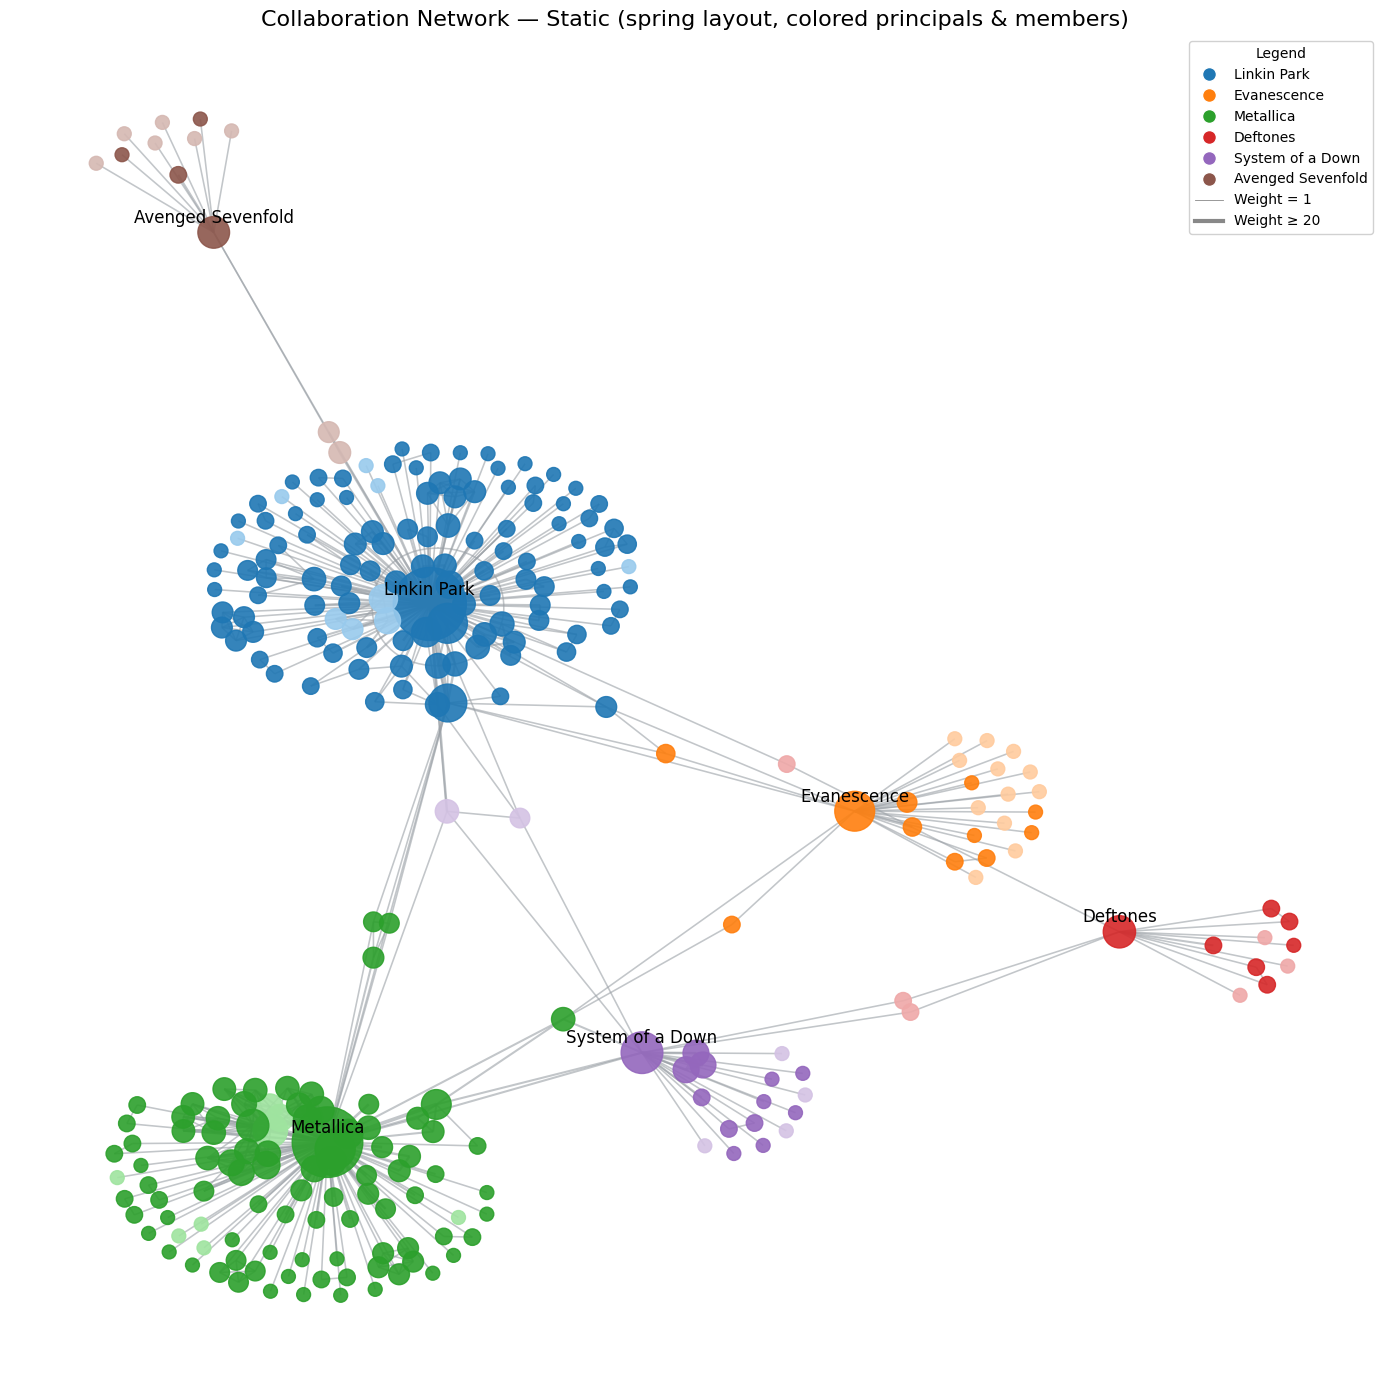

In [5]:
# === STEP 5.1 · Static visualization (spring layout, colored principals/members) ===

from __future__ import annotations
import math
from pathlib import Path
from typing import Dict, List
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import colorsys

# Globals reused:
# - collab_graph   : full graph (equiv. a tu G)
# - filtered_graph : grafo filtrado (equiv. a tu Gf)
# - principales    : Dict[MBID, BandName]
# - band_members   : Dict[BandName, List[dict]]

# ---------------------------------------
# Choose the source graph for the viz
# ---------------------------------------
USE_FULL_GRAPH_FOR_VIZ: bool = True  # <- pon False si quieres usar el filtrado
SOURCE_GRAPH = collab_graph if USE_FULL_GRAPH_FOR_VIZ else filtered_graph

# Palette (igual que la tuya)
PRINCIPAL_COLORS: Dict[str, str] = {
    "Linkin Park":        "#1f77b4",
    "Evanescence":        "#ff7f0e",
    "Metallica":          "#2ca02c",
    "Deftones":           "#d62728",
    "System of a Down":   "#9467bd",
    "Avenged Sevenfold":  "#8c564b",
}

def lighten_hex(hex_color: str, amount: float = 0.6) -> str:
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l2 = min(1.0, l + amount*(1.0 - l))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l2, s)
    return "#{:02x}{:02x}{:02x}".format(int(r2*255), int(g2*255), int(b2*255))

LIGHT_MEMBER_COLORS = {b: lighten_hex(c, 0.6) for b, c in PRINCIPAL_COLORS.items()}
COLOR_OTHER = "#cccccc"

def is_internal_member(node_name: str) -> bool:
    return any(any(m["name"] == node_name for m in members) for members in band_members.values())

def member_band(node_name: str) -> str | None:
    for band, members in band_members.items():
        if any(m["name"] == node_name for m in members):
            return band
    return None

def build_visual_subgraph(graph: nx.Graph, principal_colors: Dict[str, str]) -> nx.Graph:
    present_principals = [p for p in principal_colors if p in graph]
    nodes = set(present_principals)
    for p in present_principals:
        nodes.update(graph.neighbors(p))
    return graph.subgraph(nodes).copy()

# Igual que en tu 5.1 original: principales + vecinos
Gviz: nx.Graph = build_visual_subgraph(SOURCE_GRAPH, PRINCIPAL_COLORS)

# Layout (rescalado para ocupar el lienzo)
spring_k = 1.1 / max(1, len(Gviz))**0.5
pos = nx.spring_layout(Gviz, k=spring_k, iterations=300, seed=42, weight="weight")
pos = nx.rescale_layout_dict(pos, scale=1.0)  # evita el "pegote" en una esquina

deg = dict(Gviz.degree(weight="weight"))

# Edge widths (log)
edge_widths = [0.6 + 0.8*math.log1p(attrs.get("weight", 1)) for _, _, attrs in Gviz.edges(data=True)]

# Node sizes & colors
node_sizes: List[float] = []
node_colors: List[str] = []

for node in Gviz.nodes():
    size = (deg.get(node, 0)**0.5) * 100
    if node in PRINCIPAL_COLORS:
        size *= 1.5
    node_sizes.append(size)

    if node in PRINCIPAL_COLORS:
        node_colors.append(PRINCIPAL_COLORS[node])
    elif is_internal_member(node):
        node_colors.append(LIGHT_MEMBER_COLORS.get(member_band(node), COLOR_OTHER))
    else:
        weights_to_principals = {b: Gviz[node][b]["weight"] for b in PRINCIPAL_COLORS if Gviz.has_edge(node, b)}
        node_colors.append(PRINCIPAL_COLORS[max(weights_to_principals, key=weights_to_principals.get)]
                           if weights_to_principals else COLOR_OTHER)

# Render
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(Gviz, pos, width=edge_widths, edge_color="#9aa0a6", alpha=0.6)
nx.draw_networkx_nodes(Gviz, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# Labels only for principal bands (slight vertical offset)
label_offset = 0.02
present_principals = [b for b in PRINCIPAL_COLORS if b in Gviz]
label_pos = {b: (pos[b][0], pos[b][1] + label_offset) for b in present_principals}
nx.draw_networkx_labels(Gviz, label_pos, labels={b: b for b in present_principals}, font_size=12)

# Legend
legend_nodes = [Line2D([0],[0], marker='o', color='w', label=b, markerfacecolor=c, markersize=10)
                for b, c in PRINCIPAL_COLORS.items()]
legend_edges = [
    Line2D([0],[0], color='#888888', lw=0.6, label='Weight = 1'),
    Line2D([0],[0], color='#888888', lw=3.0, label='Weight ≥ 20'),
]
plt.legend(handles=legend_nodes + legend_edges, loc='upper right', title='Legend', framealpha=0.9)

# Final touches
Path("results").mkdir(exist_ok=True)
plt.axis('off')
plt.margins(0.02)                   # pequeño margen para que “respire”
plt.title("Collaboration Network — Static (spring layout, colored principals & members)", fontsize=16)
plt.tight_layout()
plt.savefig("results/static_network.png", dpi=300)
plt.show()


#### Analysis of the Static Graph

- **Node size**  
  Each circle is proportional to the artist’s weighted degree: the more (and stronger) collaborations an artist has, the larger their node appears.

- **Node color**  
  - **Strong colors** → the six principal bands:  
    - Linkin Park – blue  
    - Evanescence – orange  
    - Metallica – green  
    - Deftones – red  
    - System of a Down – purple  
    - Avenged Sevenfold – brown  
  - **Light tints** → internal members of each band, shown as lighter shades of their band’s color.  
  - **Inherited colors** → external collaborators, colored by the principal band they are most strongly connected to.  
  - **Gray** → neutral collaborators or those without a clear dominant connection.

- **Edge thickness**  
  Encodes the weight of collaborations:  
  - Thin line → weight = 1  
  - Thick line → weight ≥ 20  

- **Graph structure**  
  Six visible clusters radiate around each principal band.  
  - Internal members (light tones) are clearly grouped around their respective band.  
  - External collaborators (colored nodes) form bridges between different groups.  
  - Strong edges highlight the densest collaboration ties (e.g., Linkin Park–Jay-Z, Metallica–San Francisco Symphony).  

- **Overall pattern**  
  The visualization makes clear that **Linkin Park** and **Metallica** dominate the network, each with a large and diverse set of connections, while the other bands form smaller but distinct subgraphs tied to their members and collaborators.


#### Step 5.2 · Interactive Visualization

In this step, we complement the static graph with an **interactive network** built using **PyVis**, which allows dynamic exploration of the collaboration structure.  

- **Interactivity**  
  Users can zoom, drag nodes, and apply physics layouts to reorganize the network in real time. This makes it easier to identify densely connected areas and to follow connections across bands.

- **Node appearance**  
  - **Size** → proportional to the weighted degree (number of collaborations).  
  - **Color** → consistent with Step 5.1:  
    - Strong colors for the six principal bands.  
    - Lighter shades for their internal members.  
    - Inherited colors for external collaborators (linked to the band with the strongest tie).  
    - Gray for nodes without a dominant connection.

- **Tooltips**  
  Hovering over a node displays a detailed tooltip including:  
  - Artist name  
  - Role (principal band, band member, or soloist)  
  - Country of origin  
  - Formation or birth year  
  - Number of collaborations  
  - Notes or disambiguations from MusicBrainz (when available)

- **Edges**  
  - Thickness encodes collaboration weight (log-scaled).  
  - Color matches the source and target nodes if they belong to the same group, otherwise shown in neutral gray.  
  - Tooltips show the number of collaborations between the connected artists.

- **Legend**  
  A floating legend explains the color scheme for principal bands, their members, and the meaning of edge weights.

- **Output**  
  The final interactive graph is exported as an **HTML file** (`results/network.html`), which can be opened in any browser to explore the network beyond the notebook environment.


In [6]:
# === STEP 5.2 · Interactive Visualization (PyVis, EN, robust tooltips) =======

from pathlib import Path
from pyvis.network import Network
import math

# --- Preconditions from Step 5.1 ---
missing = []
for name in ["Gviz", "PRINCIPAL_COLORS", "LIGHT_MEMBER_COLORS", "band_members"]:
    if name not in globals():
        missing.append(name)
if missing:
    raise RuntimeError("Run Step 5.1 first. Missing: " + ", ".join(missing))

# Optional fallbacks (used for missing attributes)
ORIGIN_GRAPH = globals().get("collab_graph") or globals().get("filtered_graph") or Gviz

# Palettes (same as 5.1)
BASE_COLORS = PRINCIPAL_COLORS
LIGHT_COLORS = LIGHT_MEMBER_COLORS
GREY_OTHER = "#cccccc"

# -------------------------------
# Helpers
# -------------------------------
def get_node_attr(node_name: str, key: str, default: str = "–"):
    """Robust getter: Gviz → ORIGIN_GRAPH → default."""
    if Gviz.has_node(node_name) and key in Gviz.nodes[node_name]:
        val = Gviz.nodes[node_name].get(key, default)
        return default if val in (None, "", []) else val
    if ORIGIN_GRAPH.has_node(node_name) and key in ORIGIN_GRAPH.nodes[node_name]:
        val = ORIGIN_GRAPH.nodes[node_name].get(key, default)
        return default if val in (None, "", []) else val
    return default

def member_band(node_name: str):
    for band, members in band_members.items():
        if any(m.get("name") == node_name for m in members):
            return band
    return None

def assign_color(node_name: str) -> str:
    if node_name in BASE_COLORS:
        return BASE_COLORS[node_name]
    band = member_band(node_name)
    if band is not None:
        return LIGHT_COLORS.get(band, GREY_OTHER)
    weights_to_principals = {
        band: Gviz[node_name][band]["weight"]
        for band in BASE_COLORS
        if Gviz.has_edge(node_name, band)
    }
    return BASE_COLORS[max(weights_to_principals, key=weights_to_principals.get)] if weights_to_principals else GREY_OTHER

def role_and_date_label(node_name: str):
    """
    Groups    → 'Group' + ('Formed', debut)
    Members   → 'Band member' + ('Born', debut)
    Soloists  → 'Solo' + ('Born', debut)
    """
    node_type = str(get_node_attr(node_name, "type", "")).lower()   # 'gruop'/'solo'
    zone      = str(get_node_attr(node_name, "zone", "")).lower()   # 'inter'/'externa'
    debut     = str(get_node_attr(node_name, "debut", "–"))
    if node_type in ("grupo", "group"):
        return "Group", ("Formed", debut)
    if zone == "interna":
        return "Band member", ("Born", debut)
    return "Solo", ("Born", debut)

def build_title_text(node_name: str, degree_val: int) -> str:
    """Plain-text tooltip with newline separators; values filled via robust getter."""
    role, (date_label, date_value) = role_and_date_label(node_name)
    country = str(get_node_attr(node_name, "country", "–"))
    note    = str(get_node_attr(node_name, "note", "")).strip()

    lines = [
        f"Artist: {node_name}",
        f"Role: {role}",
        f"Country: {country}",
        f"{date_label}: {date_value}",
        f"Collaborations: {degree_val}",
    ]
    if note:
        lines.append(f"Note: {note}")
    return "\n".join(lines)

# -------------------------------
# PyVis
# -------------------------------
output_dir = Path("results"); output_dir.mkdir(exist_ok=True)
html_path = output_dir / "network.html"
if html_path.exists():
    html_path.unlink()

net = Network(
    height="850px", width="100%",
    bgcolor="#ffffff", font_color="black",
    notebook=False, cdn_resources="in_line"
)

# 1) Nodes (now using robust getters → no nulls)
for node_name in Gviz.nodes():
    degree_val = Gviz.degree(node_name, weight="weight")
    net.add_node(
        node_name,
        label=node_name,
        value=degree_val,
        title=build_title_text(node_name, degree_val),
        color=assign_color(node_name),
    )

# 2) Cache node colors to color edges
node_colors = {nd["id"]: nd.get("color", GREY_OTHER) for nd in net.nodes}

# 3) Edges (log width; English title)
for source_name, target_name, edge_attrs in Gviz.edges(data=True):
    weight_val = edge_attrs.get("weight", 0)
    width_val = max(0.3, math.log(weight_val + 1) * 0.3)
    color_src = node_colors.get(source_name, GREY_OTHER)
    color_tgt = node_colors.get(target_name, GREY_OTHER)
    edge_color = color_src if color_src == color_tgt else "#888888"

    net.add_edge(
        source_name, target_name,
        value=weight_val,
        title=f"{source_name} - {target_name}: {weight_val} collaborations",
        width=width_val,
        color=edge_color,
    )

# 4) Controls
net.show_buttons(filter_=["physics", "interaction"])

# 5) HTML export with tooltip CSS + legend (English)
html_core = net.generate_html(notebook=False)

tooltip_css = """
<style>
  .vis-tooltip {
    white-space: pre-line;   /* render \\n as real line breaks */
    font-family: system-ui, sans-serif;
    font-size: 12px;
  }
</style>
"""

legend_html = f"""
<style>
  #legend {{
    position:fixed; top:20px; right:20px; z-index:9999;
    background:rgba(255,255,255,0.95); padding:8px; border:1px solid #ccc;
    font-family:sans-serif; font-size:12px;
  }}
  #legend div {{ margin:4px 0; }}
  #legend span {{ display:inline-block; width:12px; height:12px; margin-right:6px; }}
  #legend hr {{ border:none; border-top:1px solid #ccc; margin:6px 0; }}
</style>
<div id="legend">
  <strong>Legend</strong>
  {''.join(f"<div><span style='background:{col};'></span>{band}</div>" for band, col in BASE_COLORS.items())}
  <hr>
  {''.join(f"<div><span style='background:{LIGHT_COLORS[band]};'></span>Member of {band}</div>" for band in BASE_COLORS)}
  <hr>
  <div><span style="border-top:2px solid #888888; width:20px; display:inline-block"></span> Weight = 1</div>
  <div><span style="border-top:4px solid #888888; width:20px; display:inline-block"></span> Weight ≥ 5</div>
</div>
"""

final_html = html_core.replace("<body>", "<body>\n" + tooltip_css + legend_html)
html_path.write_text(final_html, encoding="utf-8")

print("Interactive network saved to", html_path)


Interactive network saved to results\network.html


#### Analysis of the Interactive Graph

- **Well-defined groupings**  
  Each principal band is highlighted with a distinct base color, while its members appear in lighter shades of the same palette. This makes it easy to identify the internal structure and the surrounding community of each group.

- **Representation of collaborations**  
  Edges connecting nodes within the same band inherit the band color, visually reinforcing internal cohesion. Cross-band collaborations are shown in grey, making external connections clearly distinguishable.

- **Enhanced tooltips**  
  - **Nodes**: display key information in English, including artist name, role (Group, Band member, Solo), country, relevant date (Formed/Born), number of collaborations, and descriptive notes when available.  
  - **Edges**: indicate the exact number of collaborations between the two connected artists.

- **Advanced interaction**  
  The control panel allows adjusting physics parameters (repulsion, attraction, gravity, etc.) and toggling interaction options. This supports exploring dense areas of the network, focusing on specific nodes, and dynamically adapting the layout.

Overall, this interactive visualization provides an intuitive way to explore the collaboration network, balancing a global view of musical communities with the ability to inspect individual artists and their relationships in detail.
